In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import sys
import os
from itertools import combinations
from collections import Counter

# A. Dataset Introduction


Dataset yang akan digunakan didapatkan dari website kaggle (https://www.kaggle.com/datasets/knightbearr/sales-product-data?datasetId=1695352&sortBy=voteCount).

## **Context**

Sales analytics is the practice of generating insights from sales data, trends, and metrics to set targets and forecast future sales performance. Sales analysis is mining your data to evaluate the performance of your sales team against its goals. It provides insights about the top performing and underperforming products/services, the problems in selling and market opportunities, sales forecasting, and sales activities that generate revenue.

## **Content**

- **Order ID** - An Order ID is the number system that Amazon uses exclusively to keep track of orders. Each order receives its own Order ID that will not be duplicated. This number can be useful to the seller when attempting to find out certain details about an order such as shipment date or status.

- **Product** - The product that have been sold.

- **Quantity Ordered** - Ordered Quantity is the total item quantity ordered in the initial order (without any changes).

- **Price Each** - The price of each products.

- **Order Date** - This is the date the customer is requesting the order be shipped.

- **Purchase Address** - The purchase order is prepared by the buyer, often through a purchasing department. The purchase order, or PO, usually includes a PO number, which is useful in matching shipments with purchases; a shipping date; billing address; shipping address; and the request items, quantities and price.

## **Target**

A target market analysis is an assessment of how your product or service fits into a specific market and where it will gain the most.

## **Task**

1. What was the best month for sales? How much was earned that month?

2. What City had the highest number of sales?

3. What time should we display adverstisement to maximize likelihood of customer's buying product?

4. What products are most often sold together?

5. What product sold the most? Why do you think it sold the most?


# B. Dataset Understanding

## **Import and Read Data**

In [3]:
files = [j for j in os.listdir('/content/drive/MyDrive/Analysis/Sales Product Data/Data')]

# let's make a pandas DataFrame
data_raw = pd.DataFrame()

# makes a loop for concat the data
for file in files:
    data = pd.read_csv('/content/drive/MyDrive/Analysis/Sales Product Data/Data/' + file)
    data_raw  = pd.concat([data_raw , data])

In [4]:
data_raw.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"


## **Check Data Type**

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186850 entries, 0 to 16634
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 10.0+ MB


## **Check Missing Value**

In [6]:
data_null = data_raw.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(data_raw))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage
0,Order ID,545,0.29
1,Product,545,0.29
2,Quantity Ordered,545,0.29
3,Price Each,545,0.29
4,Order Date,545,0.29
5,Purchase Address,545,0.29


## **Check Duplicated Value** 

In [7]:
print('Total of data duplicated :', data_raw.duplicated().sum(), '\n')
data_raw[data_raw.duplicated()].sample(10)

Total of data duplicated : 1162 



,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
9928,NaN,NaN,NaN,NaN,NaN,NaN
3297,NaN,NaN,NaN,NaN,NaN,NaN
1291,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
876,NaN,NaN,NaN,NaN,NaN,NaN
8321,230857,USB-C Charging Cable,1,11.95,07/18/19 12:21,"367 Meadow St, Los Angeles, CA 90001"
1719,NaN,NaN,NaN,NaN,NaN,NaN
4173,240682,27in FHD Monitor,1,149.99,08/12/19 10:51,"869 Jefferson St, Austin, TX 73301"
8565,NaN,NaN,NaN,NaN,NaN,NaN
20134,NaN,NaN,NaN,NaN,NaN,NaN
6204,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


## **Observation**

From Dataset, we know that:

1. Several columns, such as `Quantity Ordered` , `Price Each` , and `Order Date` has an **incorrect data type**.

2. There are **missing values**, about **0.29%** of total data.

3. There are **duplicate values**, about 1162 rows of total data.

What to do next:

1. Delete rows that contain missing values.

2. Remove duplicate data.

3. Change the data type that does not match.

4. Extract year, month, and time data from columns `Order Date`.

5. Extract city data from column `Purchase Address`.

6. Extract total sales from columns `Quantity Ordered` and `Price Each`.

# C. Pre-Processing

In [8]:
data = data_raw.copy()

## **Handling Missing Value**

Deleted data rows that have missing values, because the amount of missing data is very small, which is 0.29% of the total data.

In [9]:
data = data.dropna()
data.isna().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

## **Handling Duplicated Value**

Duplicate data is deleted, so there is no double stored.


In [10]:
data = data.drop_duplicates()
print('Total of data duplicated after Handled :', data.duplicated().sum(), '\n')

Total of data duplicated after Handled : 0 



## Change the data type

In [11]:
data = data[data['Order Date'].str[0:2] != 'Or']

data['Order ID'] = data['Order ID'].astype(int)
data['Quantity Ordered'] = data['Quantity Ordered'].astype(int)
data['Price Each'] = data['Price Each'].astype(float)
data['Order Date'] = pd.to_datetime(data['Order Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185686 entries, 0 to 16634
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185686 non-null  int64         
 1   Product           185686 non-null  object        
 2   Quantity Ordered  185686 non-null  int64         
 3   Price Each        185686 non-null  float64       
 4   Order Date        185686 non-null  datetime64[ns]
 5   Purchase Address  185686 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.9+ MB


## **Extract Data**

In [13]:
def extract_data(DataFrame):

  DataFrame['Year'] = pd.DatetimeIndex(DataFrame['Order Date']).year

  DataFrame['Month'] = pd.DatetimeIndex(DataFrame['Order Date']).month

  DataFrame['Hour'] = pd.DatetimeIndex(DataFrame['Order Date']).hour

  DataFrame['Total Sales'] = DataFrame['Quantity Ordered'] * DataFrame['Price Each']

  return DataFrame

In [14]:
data = extract_data(data)

city = []
for index, columns in data.iterrows():
  split_city = columns['Purchase Address'].split(', ')[1]
  city.append(split_city)

data['City'] = city

data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Year,Month,Hour,Total Sales,City
0,141234,iPhone,1,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",2019,1,21,700.00,Boston
1,141235,Lightning Charging Cable,1,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",2019,1,14,14.95,Portland
2,141236,Wired Headphones,2,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",2019,1,13,23.98,San Francisco
3,141237,27in FHD Monitor,1,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",2019,1,20,149.99,Los Angeles
4,141238,Wired Headphones,1,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",2019,1,11,11.99,Austin


# D. Exploratory Data Analysis

In [15]:
df = data.copy()

data[data['Year']!=2019]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Year,Month,Hour,Total Sales,City
1563,297150,Lightning Charging Cable,1,14.95,2020-01-01 00:38:00,"427 Wilson St, Dallas, TX 75001",2020,1,0,14.95,Dallas
2265,297817,iPhone,1,700.00,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001",2020,1,0,700.00,New York City
2266,297817,Lightning Charging Cable,2,14.95,2020-01-01 00:22:00,"519 13th St, New York City, NY 10001",2020,1,0,29.90,New York City
2425,297969,Google Phone,1,600.00,2020-01-01 00:54:00,"542 2nd St, San Francisco, CA 94016",2020,1,0,600.00,San Francisco
2806,298344,Wired Headphones,4,11.99,2020-01-01 03:34:00,"731 7th St, New York City, NY 10001",2020,1,3,47.96,New York City
3553,299049,Apple Airpods Headphones,1,150.00,2020-01-01 01:17:00,"762 Johnson St, San Francisco, CA 94016",2020,1,1,150.00,San Francisco
3633,299125,USB-C Charging Cable,1,11.95,2020-01-01 04:21:00,"754 Hickory St, New York City, NY 10001",2020,1,4,11.95,New York City
4941,300362,USB-C Charging Cable,1,11.95,2020-01-01 00:59:00,"581 River St, San Francisco, CA 94016",2020,1,0,11.95,San Francisco
5103,300519,Bose SoundSport Headphones,1,99.99,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001",2020,1,5,99.99,New York City
5104,300519,Lightning Charging Cable,1,14.95,2020-01-01 05:13:00,"657 Spruce St, New York City, NY 10001",2020,1,5,14.95,New York City


In [16]:
print('Total order not in 2019 :', len(data[data['Year']!=2019]))

Total order not in 2019 : 34


**Notes**:

There are 34 data orders made in 2020. It can be seen that orders in 2020 were only recorded in January (1). Therefore, this analysis will focus on 2019.

In [17]:
df.drop(df[df['Year']!=2019].index, inplace=True)

In [18]:
print('Total order not in 2019 :', len(df[df['Year']!=2019]))

Total order not in 2019 : 0


## **Task**

### **1. What was the best month for sales? How much was earned that month?**

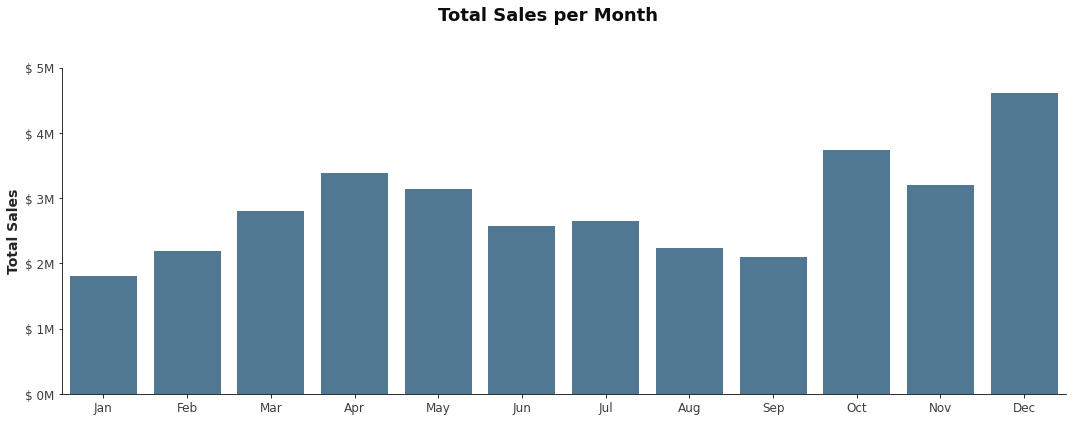

In [19]:
sales_per_month = df.groupby('Month')[['Total Sales']].sum().sort_values('Total Sales', ascending=False).reset_index()

fig, ax = plt.subplots(1, 1,figsize=(18,6))
fig.suptitle('Total Sales per Month', fontsize=18, verticalalignment='bottom', weight = 'bold', alpha = .95)

color = ['#457B9D']
sns.barplot(x='Month', y='Total Sales', data=sales_per_month, palette=color)
ax.set_ylabel('Total Sales', fontsize=14, weight = 'bold', alpha = .85)    
ax.set_xlabel('')
ax.set_xticklabels(labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], fontsize=12, alpha = .75)
ax.set_yticklabels(labels = ['$ 0M','$ 1M','$ 2M','$ 3M','$ 4M','$ 5M'], fontsize=12, alpha = .75)
ax.set_ylim(0, 5000000)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### **2. What City had the highest number of sales?**

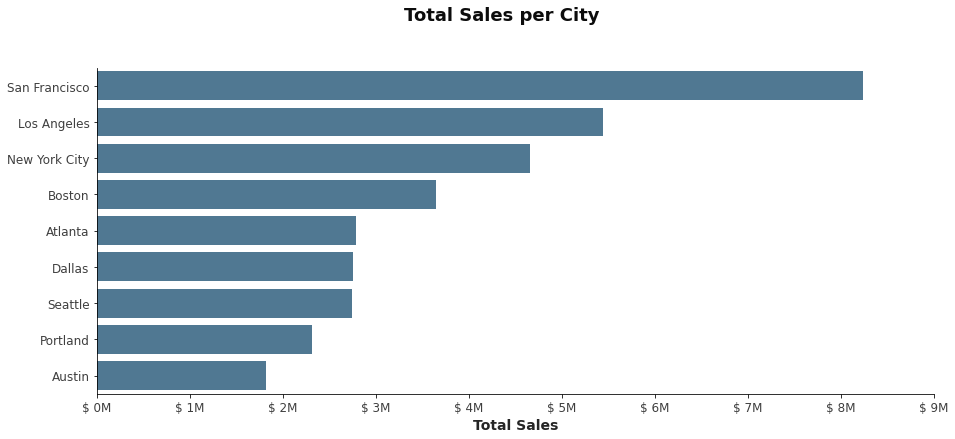

In [84]:
sales_per_city = df.groupby('City')[['Total Sales']].sum().sort_values('Total Sales', ascending=False).reset_index()

fig, ax = plt.subplots(1, 1,figsize=(15,6))
fig.suptitle('Total Sales per City', fontsize=18, verticalalignment='bottom', weight = 'bold', alpha = .95)

color = ['#457B9D']
sns.barplot(x='Total Sales', y='City', data=sales_per_city, palette=color)
ax.set_ylabel('')    
ax.set_xlabel('Total Sales', fontsize=14, weight = 'bold', alpha = .85)
ax.set_yticklabels(labels = ['San Francisco','Los Angeles','New York City','Boston','Atlanta','Dallas','Seattle','Portland','Austin'], fontsize=12, alpha = .75)
ax.set_xticklabels(labels = ['$ 0M','$ 1M','$ 2M','$ 3M','$ 4M','$ 5M','$ 6M','$ 7M','$ 8M','$ 9M'], fontsize=12, alpha = .75)
ax.set_xlim(0, 9000000)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### **3. What time should we display adverstisement to maximize likelihood of customer's buying product?**

Text(14, 13000, '12:00\nor\n12 PM')

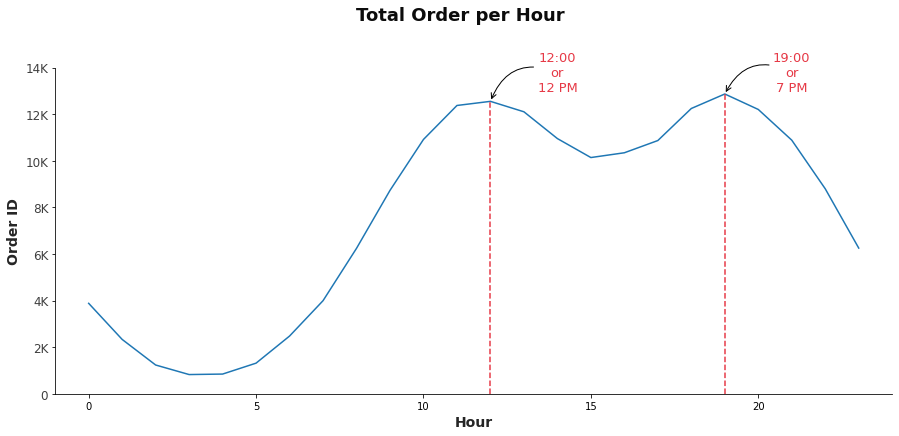

In [21]:
order_per_hour = df.groupby('Hour').agg({'Order ID':'count',
                                         'Total Sales':'sum'}).sort_values('Hour').reset_index()

fig, ax = plt.subplots(1, 1,figsize=(15,6))
fig.suptitle('Total Order per Hour', fontsize=18, verticalalignment='bottom', weight = 'bold', alpha = .95)

color = ['#457B9D']
sns.lineplot(data=order_per_hour, x='Hour', y='Order ID', palette=color)
ax.set_ylabel('Order ID', fontsize=14, weight = 'bold', alpha = .85)    
ax.set_xlabel('Hour', fontsize=14, weight = 'bold', alpha = .85)
ax.set_yticklabels(labels = ['0','2K','4K','6K','8K','10K','12K','14K'], fontsize=12, alpha = .75)
ax.set_ylim(0, 14000)
ax.set_xlim(-1, 24)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.axvline(19, color='#E63946', linestyle='--', ymin=0, ymax=0.925)
plt.axvline(12, color='#E63946', linestyle='--', ymin=0, ymax=0.9)
ax.annotate('19:00\nor\n7 PM', xy=(19, 12869), xytext=(21, 13000),
             arrowprops=dict(facecolor='steelblue',arrowstyle='->',connectionstyle="arc3,rad=.5"), fontsize=13,ha='center', color='#E63946')
ax.annotate('12:00\nor\n12 PM', xy=(12, 12553), xytext=(14, 13000),
             arrowprops=dict(facecolor='steelblue',arrowstyle='->',connectionstyle="arc3,rad=.5"), fontsize=13,ha='center', color='#E63946')

### **4. What products are most often sold together?**

In [22]:
products = df.copy()

products['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
products = products[['Order ID', 'Grouped']].drop_duplicates()
count = Counter()
for row in products['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))   

for key, value in count.most_common(5):
  print(key, value)

('iPhone', 'Lightning Charging Cable') 1000
('Google Phone', 'USB-C Charging Cable') 982
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 410
('Vareebadd Phone', 'USB-C Charging Cable') 359


### **5. What product sold the most? Why do you think it sold the most?**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


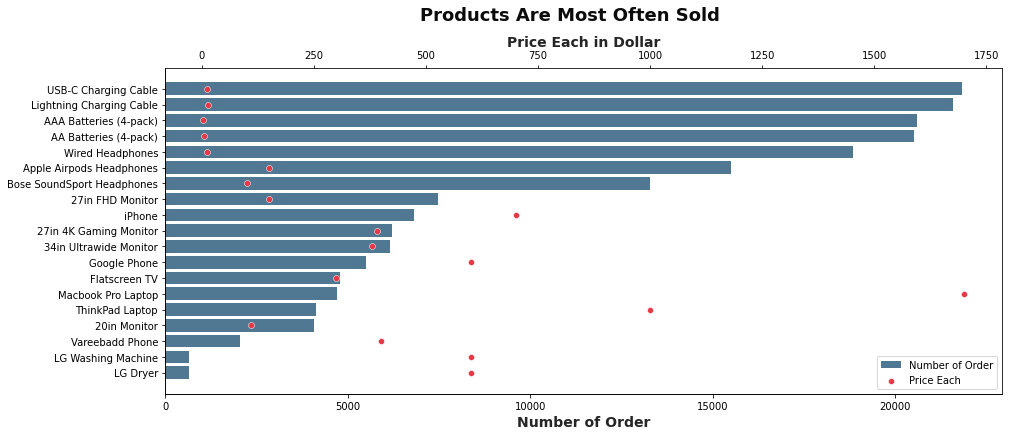

In [77]:
most_product_sold = df.groupby('Product').agg({'Order ID':'count',
                           'Price Each':'mean'}).sort_values('Order ID', ascending=False).reset_index()

fig, ax = plt.subplots(1, 1,figsize=(15,6))
fig.suptitle("Products Are Most Often Sold", fontsize=18, verticalalignment="bottom", weight = 'bold', alpha = .95)

color = ['#457B9D']
sns.barplot(x='Order ID', y='Product', data=most_product_sold, palette=color, label='Number of Order').set(xlabel='Number of Order')

ax.set_ylabel('')    
ax.set_xlabel('Number of Order', fontsize=14, weight = 'bold', alpha = .85)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2 = ax.twiny()
ax2.grid(False)

sns.scatterplot(x='Price Each', y='Product', data=most_product_sold, color='#E63946', label='Price Each').set(xlabel='Price Each')
ax2.set_xlabel('Price Each in Dollar', fontsize=14, weight = 'bold', alpha = .85)

ax2.legend().set_visible(False)
fig.legend(loc='best', bbox_to_anchor=(1,.13), bbox_transform=ax2.transAxes) 

**Oberservation:**

1. Total sales per month have a fluctuating value. However, December was the highest month for total sales generated followed by October. It can be said that the 4th quarter period (October - December) has the highest total sales.

2. The city of Austin became the city with the highest total sales.

3. 12 PM and 7 PM are the times when customers make the most transactions.

4. iPhone & Lightning Charging Cable, Google Phone & USB-C Charging Cable, iPhone & Wired Headphones, Google Phone & Wired Headphones, and Vareebadd Phone & USB-C Charging Cable were the most purchased products together with a total order of consecutively 1000, 982, 447, 410, and 359.

5. USB-C Charging Cables, Lightning Charging Cables, AAA Batteries (4-Pack), AA Batteries (4-Packs), and Wired Headphones were the 5 highest products sold in 2019. This was because these products were also the 5 lowest prices of the total products sold in 2019.